In [1]:
import os
import cv2
import numpy as np
from IPython.display import Image, display

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

from keras.models import load_model, Model
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.applications.xception import  preprocess_input

In [57]:
import os
import cv2
import numpy as np
from IPython.display import Image, display

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

from keras.models import load_model, Model
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.applications.xception import  preprocess_input


def get_data_2_pred(file,size):
    image = load_img(file,target_size=img_size)
    data = img_to_array(image)
    samples = np.expand_dims(data, 0)
    datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=15, 
                              zoom_range=0.15,
                              )
    
    it = datagen.flow(samples,batch_size=1)
    
    return it 

def get_last_layer(pred_class):
    if pred_class == 0 : last_conv_layer_name = "conv5_block13_2_conv"
    elif pred_class == 1: last_conv_layer_name ="conv5_block12_2_conv"
    else: last_conv_layer_name = "conv5_block16_2_conv"
        
    return last_conv_layer_name

def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="grad-cam.jpg", alpha=2):
    img = load_img(img_path)
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    


    plasma = cm.get_cmap("plasma")

    colors = plasma(np.arange(256))[:, :3]
    plasma_heatmap = colors[heatmap]
    plasma_heatmap = array_to_img(plasma_heatmap)
    plasma_heatmap = plasma_heatmap.resize((img.shape[1], img.shape[0]))
    plasma_heatmap = img_to_array(plasma_heatmap)
    
    

    superimposed_img_arr = plasma_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img_arr)
    superimposed_img.save(cam_path)
    
    temp = array_to_img(plasma_heatmap * alpha)
    temp.save("temp.png")
    display(Image("temp.png"))
    display(Image(cam_path))

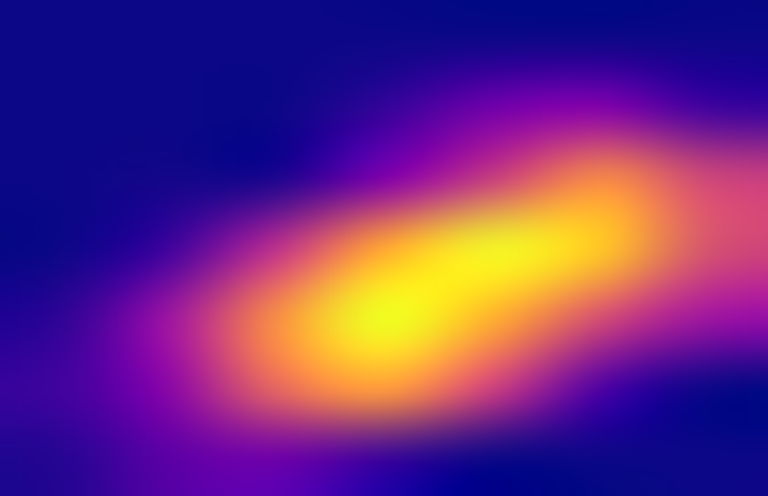

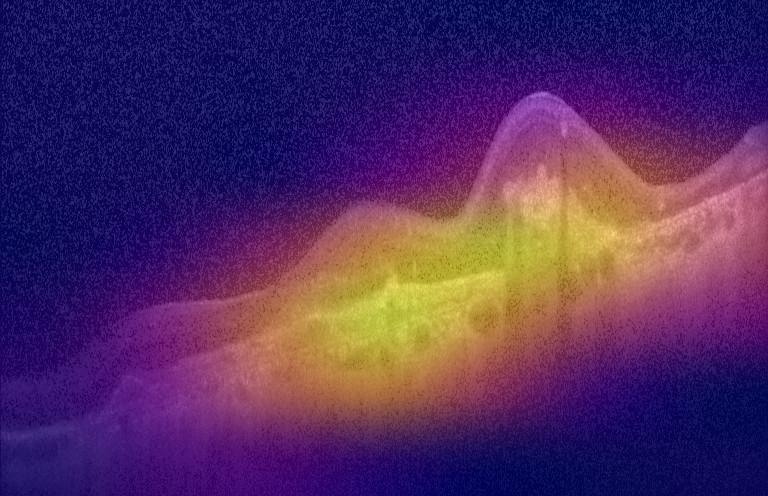

In [59]:
if __name__ == "__main__":
    img_size = (224,224)
    file = 'OCT2017/test/CNV/CNV-6215140-2.jpeg'
    model = load_model("DenseNet121.h5")
    data = get_data_2_pred(file,img_size)
    predicted = model.predict(data)
    pred_class = np.argmax(predicted)
    grad_pred_class = pred_class
    if pred_class == 3: grad_pred_class = np.argmax(predicted[0,:3])
    last_conv_layer = get_last_layer(grad_pred_class)
    model.layers[-1].activation = None
    img_array = preprocess_input(get_img_array(file, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer, grad_pred_class)
    save_and_display_gradcam(file, heatmap,alpha=1.5)
    img = cv2.imread(file)
    im_grad = cv2.imread("grad-cam.jpg")
    heatmap_im = cv2.imread("temp.png")
    compare = np.hstack((img,heatmap_im,im_grad))
    cv2.imwrite('im_out.jpg', compare)

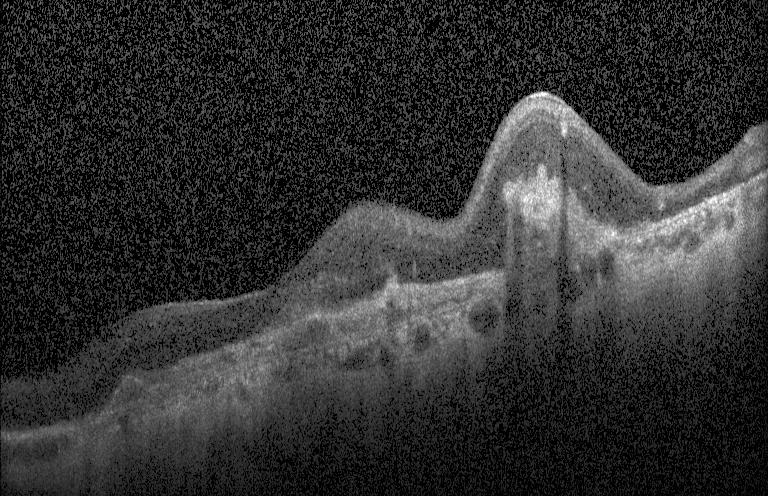

In [60]:
display(Image('OCT2017/test/CNV/CNV-6215140-2.jpeg'))